# The scenario
The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

import warnings
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_price_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


house_price_df.describe(include='all')

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


# <font color='red'>Bring in data handling from previos doc</font>

- Include interest rate date for those years into the model
- Create total living area feature
- Create overall quality feature
- Create overall property size feature
- Find financial data to reflect economical activity (customer ability to purchase house and investors likelihood to invest in real estate)


In [3]:
# import interest data and merge with house sale year and month
mortgage_file_path = '/Users/wesamazaizeh/Desktop/Thinkful_Main_Course/Linear_Regression/30-year-fixed-mortgage-rate-chart.csv'
mortgage_apr_df = pd.read_csv(mortgage_file_path, skiprows=15)

mortgage_apr_df['date'] = pd.to_datetime( mortgage_apr_df.date, format='%Y-%m-%d')
mortgage_apr_df['year'] = mortgage_apr_df.date.dt.year
mortgage_apr_df['month'] = mortgage_apr_df.date.dt.month

house_price_df2 = pd.merge(house_price_df, mortgage_apr_df, left_on=['yrsold','mosold'], right_on=['year', 'month'], how='left').drop(['date', 'year', 'month'], axis=1)
house_price_df2.rename(columns={' value':'interest'}, inplace=True)

## Model preperation

In [4]:
# Total living area
house_price_df2['totalsf'] = house_price_df2.totalbsmtsf + house_price_df2.firstflrsf + house_price_df2.secondflrsf

# Drop columns with more than 10% missing values
n_cols = house_price_df2.shape[1]
house_price_df2 = house_price_df2.loc[:, house_price_df2.isnull().sum()/house_price_df2.shape[0] < 0.10]
print('{} columns dropped'.format(n_cols - house_price_df2.shape[1]))

# # Drop rows mith missing values
# n_rows = house_price_df.isna()

6 columns dropped


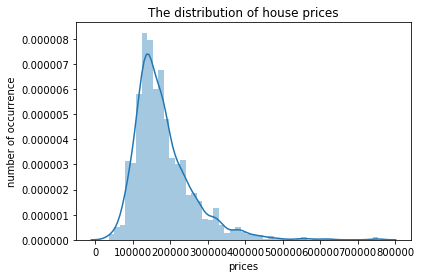

In [5]:
# Distribution of target feature
sns.distplot(house_price_df2.saleprice)
plt.title("The distribution of house prices")
plt.xlabel("prices")
plt.ylabel("number of occurrence")
plt.show()

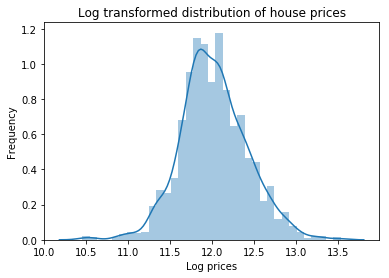

In [6]:
# log transform data to make it normal. Then, check normality of distribution
sns.distplot(np.log(house_price_df2.saleprice))
plt.title("Log transformed distribution of house prices")
plt.xlabel("Log prices")
plt.ylabel("Frequency")
plt.show()

# normality test

In [7]:
# Try model with ALL features

data = house_price_df2[house_price_df2._get_numeric_data().columns.difference(['saleprice'])]
target = house_price_df2['saleprice']

sm_data = sm.add_constant(data)

results = sm.OLS(target, sm_data).fit()

results.summary()

# still need to interpolate to take care of missing data. Apparently, there is some missing data 
# in the saleprice columns as well

MissingDataError: exog contains inf or nans